In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import os
import re
import sys
import json
import unidecode
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 

import seaborn as sns
from matplotlib import pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_colwidth', -1)

SPACE_REGEX = re.compile(r"\s+")
REGEX_TOKENIZER = RegexpTokenizer(r'\w+')

STOP_WORDS = set(stopwords.words('english'))

In [3]:
HOME_DIR = r'C:\ProjectX'

WORKSPACE_ROOT = os.path.join(HOME_DIR, 'workspace')
PATH_TO_PROJECT_X_REPO = os.path.join(WORKSPACE_ROOT, 'project_x')
PATH_TO_DATA_ROOT_DIR = os.path.join(WORKSPACE_ROOT, "data")
PATH_TO_SCRAPED_NEWS = os.path.join(PATH_TO_DATA_ROOT_DIR, "data_providers\gdelt\scraped_news")

In [4]:
# Add path to library to sys path
generic_utils_lib_dir = os.path.join(PATH_TO_PROJECT_X_REPO, 'common')

sys.path.extend([generic_utils_lib_dir])

#from generic_utils import (downcast_datatypes, timing, create_output_dir, parallelize)

from crime_mapper_utils import crimemapper, map_event_types_from_es_to_en

In [5]:
def squash_spaces(s, space_re=SPACE_REGEX) -> str:
    return re.sub(space_re, " ", s) if isinstance(s, str) else s

def remove_stop_words_from_document(doc, tokenizer=REGEX_TOKENIZER, stop_words=STOP_WORDS):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

def preprocess_body_text(text, normalize=True, remove_stop_words=False):
    
    if text:
        # Replacing possible issues with data. We can add or reduce the replacement in this chain
        s = re.sub(r'\n+', ' ', str(text))
        s = squash_spaces(s).strip()

        if normalize:
            # Normalizing / encoding the text
            s = unidecode.unidecode(s)

        if remove_stop_words:
            s = remove_stop_words_from_document(s)
        
        return s
    return text

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(12.0,8.0),
                   title: str = None, title_size: int = 24):

    wordcloud = WordCloud(background_color='black',
                          stopwords=STOP_WORDS,
                          max_words=max_words,
                          max_font_size=max_font_size,
                          random_state=SEED,
                          width=1200,
                          height=600,
                          mask=mask)

    wordcloud.generate(str(text))

    plt.figure(figsize=figure_size)

    plt.imshow(wordcloud)
    plt.title(title, fontdict={'size': title_size, 'color': 'black',
                              'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    
def apply_crime_mapper_on_chunk(data):
    data = data.apply(lambda x: crimemapper(x) if isinstance (x, str) else np.NaN)
    data = data.apply(lambda x: map_event_types_from_es_to_en[x] if isinstance(x, str)
                                                                    and x in map_event_types_from_es_to_en else x)
    return data

## EDA

In [6]:
news_df = pd.read_csv(os.path.join(PATH_TO_SCRAPED_NEWS, 'events_gkg_v02_en_with_news_text_2022-07-01_2022-10-01.csv'))

In [7]:
news_df.head()

,source_name,url,status,paragraphs,final_tags,error_code,paragraphs_nwords,globaleventid,sqldate,dateadded,eventrootcode,eventbasecode,eventcode,goldsteinscale,actiongeo_fullname,actiongeo_countrycode,actiongeo_countrycode_iso2,actiongeo_countrycode_iso3,actiongeo_lat,actiongeo_long,gkgrecordid,date,sourcecommonname,v2locations,v2themes_names,v2counts_names,dates,translationinfo
0,www.myanmarnews.net,https://www.myanmarnews.net/news/272606117/un-...,200,"Voice of America 01 Jul 2022, 04:06 GMT+10 Gen...",{'title': 'UN Investigator Warns of Increased ...,200 - Successful - OK,573.0,1.052049e+09,2022-07-01 00:00:00,2022-07-01 00:00:00,19.0,190.0,190.0,-10.0,"Geneva, GenÃ¨, Switzerland",SZ,CH,CHE,46.19560,6.14811,20220701000000-138,2022-07-01 00:00:00,myanmarnews.net,"4#Naypyitaw, Mandalay, Myanmar#BM#BM08#41807#1...",['AFFECT' 'ARMEDCONFLICT' 'ARREST' 'CRISISLEX_...,['AFFECT' 'ARREST' 'CRISISLEX_C07_SAFETY' 'CRI...,NaN,NaN
1,www.cbsnews.com,https://www.cbsnews.com/news/law-enforcement-c...,200,"By Jennifer De Pinto, Fred Backus, Anthony Sal...","{'type': 'article', 'url': 'https://www.cbsnew...",200 - Successful - OK,781.0,1.052050e+09,2022-07-01 00:00:00,2022-07-01 00:00:00,1.0,12.0,12.0,-0.4,"Uvalde, Texas, United States",US,US,USA,29.20970,-99.78620,20220701000000-647,2022-07-01 00:00:00,cbsnews.com,"2#Texans, United States#US#USTX##31.106#-97.64...",['BAN' 'CRISISLEX_C07_SAFETY' 'CRISISLEX_CRISI...,NaN,NaN,NaN
2,www.wkyc.com,https://www.wkyc.com/article/news/nation-world...,200,Next up in Example video title will go here fo...,{'url': 'https://www.wkyc.com/article/news/nat...,200 - Successful - OK,996.0,1.052049e+09,2022-07-01 00:00:00,2022-07-01 00:00:00,19.0,190.0,190.0,-10.0,"Tijuana, Baja California, Mexico",MX,MX,MEX,32.53330,-117.01700,20220701000000-534,2022-07-01 00:00:00,wkyc.com,"2#Texas, United States#US#USTX##31.106#-97.647...",['AFFECT' 'ARMEDCONFLICT' 'BORDER' 'CRISISLEX_...,['AFFECT' 'EPU_CATS_MIGRATION_FEAR_MIGRATION' ...,NaN,NaN
3,www.850wftl.com,https://www.850wftl.com/four-dead-three-injure...,200,"(ENCINAL, Texas) — Four people were killed and...","{'title': 'Four dead, three injured in Texas c...",200 - Successful - OK,107.0,1.052048e+09,2022-07-01 00:00:00,2022-07-01 00:00:00,19.0,190.0,190.0,-10.0,"San Antonio, Texas, United States",US,US,USA,29.42410,-98.49360,20220701000000-742,2022-07-01 00:00:00,850wftl.com,"3#Texas Department Of Public Safety, Texas, Un...",['BORDER' 'CRISISLEX_C07_SAFETY' 'CRISISLEX_CR...,['CRISISLEX_T03_DEAD' 'KILL'],NaN,NaN
4,www.herald.ng,https://www.herald.ng/nigerian-army-confirms-a...,200,"Get real time updates directly on you device, ...","{'locale': 'en_US', 'type': 'article', 'title'...",200 - Successful - OK,289.0,1.052048e+09,2022-07-01 00:00:00,2022-07-01 00:00:00,19.0,190.0,190.0,-10.0,"Shiroro, Niger, Nigeria",NI,NG,NGA,9.96167,6.83694,20220701000000-461,2022-07-01 00:00:00,herald.ng,"4#Shiroro, Niger, Nigeria#NI#NI31#191109#9.961...",['ARMEDCONFLICT' 'CRISISLEX_CRISISLEXREC' 'ENV...,NaN,NaN,NaN


In [8]:
print(f"original number of records: {news_df.shape[0]}")
print(f"original number of columns: {news_df.shape[1]}")

print("\nOriginal columns:")
print(news_df.columns.values)

original number of records: 156340
original number of columns: 28

Original columns:
['source_name' 'url' 'status' 'paragraphs' 'final_tags' 'error_code'
 'paragraphs_nwords' 'globaleventid' 'sqldate' 'dateadded' 'eventrootcode'
 'eventbasecode' 'eventcode' 'goldsteinscale' 'actiongeo_fullname'
 'actiongeo_countrycode' 'actiongeo_countrycode_iso2'
 'actiongeo_countrycode_iso3' 'actiongeo_lat' 'actiongeo_long'
 'gkgrecordid' 'date' 'sourcecommonname' 'v2locations' 'v2themes_names'
 'v2counts_names' 'dates' 'translationinfo']


`explore columns: 'paragraphs', 'paragraphs_nwords', 'sqldate' 'dateadded' 'date', 'actiongeo_countrycode_iso3', 'v2themes_names',
 'v2counts_names'`

In [9]:
news_df.sample(5)['paragraphs'].reset_index(drop=True).to_dict()

{0: "Next up in Example video title will go here for this video ATLANTA — The mystery of an continued to unfold slowly Friday night, one week after she was spending what would be her last night at home. Debbie Collier, 59, vanished the next day, Saturday, Sept. 10. Her body was found the day after that, an hour away near her SUV in some woods off of U.S. 441 in Habersham County, in north Georgia. Investigators are releasing few details about her last hours of life, confirming only that they’re treating her death as a homicide, not a suicide. They are also focusing on her daughter’s disturbing statement to police, pointing to what might have been a violent kidnapping. However, releases from the sheriff’s office about the investigation remain few and terse. What had brought Debbie Collier to that area of Habersham County, so far from her Athens home? Who would have attacked her? Was she killed where her body was found, or somewhere else and taken there? At the crime scene Sunday, Sept. 1

### paragraphs_nwords statistics

In [10]:
news_df['paragraphs_nwords'].describe()

count    156340.000000
mean        661.582295
std         868.154281
min           1.000000
25%         267.000000
50%         476.000000
75%         809.000000
max       51753.000000
Name: paragraphs_nwords, dtype: float64

In [11]:
news_df['paragraphs_nwords'].quantile(0.95)

1668.0

In [12]:
nwords_count = pd.DataFrame(news_df['paragraphs_nwords'].value_counts().sort_index().rename('count'))
nwords_count = nwords_count.reset_index().rename(columns={'index': 'paragraphs_nwords'})
nwords_count['cumsum'] = nwords_count['count'].cumsum()
nwords_count.head(100)

,paragraphs_nwords,count,cumsum
0,1.0,245,245
1,2.0,34,279
2,3.0,101,380
3,4.0,85,465
4,5.0,677,1142
5,6.0,76,1218
6,7.0,104,1322
7,8.0,87,1409
8,9.0,81,1490
9,10.0,467,1957


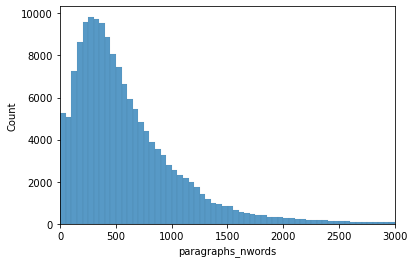

In [13]:
sns.histplot(data=news_df, x='paragraphs_nwords', binwidth=50)
_ = plt.xlim(0, 3000)

In [14]:
# explore a few paragraphs with nwords = 50/60/70
news_df[news_df['paragraphs_nwords'] == 70].sample(10)['paragraphs'].reset_index(drop=True).to_dict()

{0: 'Catch up with the big stories of the past 24 hours… A caregiver at the St Jude’s Home for Girls is ambushed during a daring attempt to escape Scrap iron dealers strongly reject Government’s plan to temporarily shut down the industry The Public Utilities Minister attempts to wash away what he says are ‘Opposition lies’ Police hope the discovery of the murder weapon will lead them to Kareen Ramlal’s killer',
 1: 'July 20, 2022 : Fathers John Mark Cheitnum and Donatus Cleophas were on July 15. The former was brutally murdered; the latter escaped. For all current news, . All comments are moderated. To lighten our editing burden, only current donors are allowed to Sound Off. If you are a current donor, to see the comment form; otherwise please , and Sound Off! There are no comments yet for this item.',
 2: '- The Border Service of the State National Security Committee of Tajikistan said at around 7:15 a... To Read the Full Story All rights reserved © AKIpress News Agency - 2001-2022. R

### sqldate, dateadded, date exploration

In [15]:
news_df[['sqldate', 'dateadded', 'date']].isnull().sum()

sqldate      581
dateadded    581
date         897
dtype: int64

In [16]:
sql = pd.to_datetime(news_df['sqldate'])
dateadded = pd.to_datetime(news_df['dateadded'])

In [17]:
sql[100], dateadded[100]

(Timestamp('2021-07-01 00:00:00'), Timestamp('2022-07-01 00:30:00'))

### actiongeo countrycode iso3 count

In [18]:
country_codes = pd.read_csv(os.path.join(PATH_TO_PROJECT_X_REPO, "auxiliary_data", "countries_fips_to_iso2.csv"))
country_codes.head()

,country_name,fips_10_4,iso2,iso3
0,Afghanistan,AF,AF,AFG
1,Akrotiri,AX,NaN,NaN
2,Albania,AL,AL,ALB
3,Algeria,AG,DZ,DZA
4,American Samoa,AQ,AS,ASM


In [19]:
iso3_counts = news_df['actiongeo_countrycode_iso3'].value_counts().sort_values(ascending=False)
iso3_counts = iso3_counts.rename('counts').reset_index().rename(columns={'index' : 'iso3'})
iso3_counts = pd.merge(country_codes.groupby('iso3')['country_name'].apply(list), iso3_counts, on='iso3')[["country_name", "iso3", "counts"]]
iso3_counts = iso3_counts.sort_values("counts", ascending=False).reset_index(drop=True)
iso3_counts.head(10)

,country_name,iso3,counts
0,[United States],USA,56154
1,"[Guernsey, Isle of Man, Jersey, United Kingdom]",GBR,6946
2,[India],IND,6761
3,[Ukraine],UKR,5763
4,"[Russia, Russia]",RUS,5444
5,[Canada],CAN,3686
6,[Israel],ISR,3570
7,[China],CHN,3256
8,[Pakistan],PAK,2862
9,"[Ashmore and Cartier Islands, Australia, Coral...",AUS,2725


### v2themes_names

In [20]:
def extract_themes_names(x):
    if not pd.isnull(x):
        return squash_spaces(x)[2:-2].split("' '")
    return np.nan

In [21]:
themes = news_df['v2themes_names'][:10].apply(extract_themes_names)
themes.explode(['v2themes_names']).value_counts(normalize=True).head(10).round(3)*100.

CRISISLEX_CRISISLEXREC             2.6
CRISISLEX_C07_SAFETY               2.3
MANMADE_DISASTER_IMPLIED           1.7
UNGP_FORESTS_RIVERS_OCEANS         1.7
WB_840_JUSTICE                     1.7
WB_696_PUBLIC_SECTOR_MANAGEMENT    1.7
WB_1014_CRIMINAL_JUSTICE           1.7
TRIAL                              1.4
SECURITY_SERVICES                  1.1
UNGP_CRIME_VIOLENCE                1.1
Name: v2themes_names, dtype: float64

### v2counts_names

In [22]:
mask = news_df['v2counts_names'].isnull()

print(f"v2counts_names has {round(mask.sum()/news_df.shape[0]*100, 2)}% NaN")

v2counts_names has 62.04% NaN


In [23]:
news_df.loc[~mask, 'v2counts_names'].head(10)

0     ['AFFECT' 'ARREST' 'CRISISLEX_C07_SAFETY' 'CRI...
2     ['AFFECT' 'EPU_CATS_MIGRATION_FEAR_MIGRATION' ...
3                         ['CRISISLEX_T03_DEAD' 'KILL']
17    ['CRISISLEX_CRISISLEXREC' 'CRISISLEX_T02_INJUR...
23    ['CRISISLEX_C03_WELLBEING_HEALTH' 'CRISISLEX_C...
25                                             ['KILL']
27    ['ARMEDCONFLICT' 'CRISISLEX_T03_DEAD' 'KILL' '...
29                    ['ARREST' 'CRISISLEX_C07_SAFETY']
30               ['AFFECT' 'CRISISLEX_T03_DEAD' 'KILL']
36       ['AFFECT' 'CRISISLEX_C04_LOGISTICS_TRANSPORT']
Name: v2counts_names, dtype: object

### final_tags

In [24]:
def extract_tags(x):
    try:
        return list(json.loads(x.replace("\'", "\"")).keys())
    except:
        return np.nan

In [25]:
tags = news_df['final_tags'].apply(extract_tags)
tags.explode(['final_tags']).value_counts(normalize=True).round(3)*100

title                       12.2
image                       12.2
url                         12.0
type                        11.9
description                 11.6
site_name                   10.6
image:width                  7.5
image:height                 7.4
locale                       4.8
image:type                   2.1
section                      1.6
image:secure_url             1.2
image:alt                    1.1
image:url                    0.9
updated_time                 0.8
article:published_time       0.3
language                     0.2
name                         0.1
video:type                   0.1
video:width                  0.1
video:height                 0.1
article:section              0.1
video                        0.1
locale:alternate             0.1
video:secure_url             0.1
video:url                    0.1
publish_date                 0.1
ttl                          0.1
audio                        0.0
author                       0.0
category  

### source_name

In [26]:
news_df[['source_name', 'sourcecommonname']]

,source_name,sourcecommonname
0,www.myanmarnews.net,myanmarnews.net
1,www.cbsnews.com,cbsnews.com
2,www.wkyc.com,wkyc.com
3,www.850wftl.com,850wftl.com
4,www.herald.ng,herald.ng
...,...,...
156335,news.yahoo.com,NaN
156336,www.smh.com.au,NaN
156337,www.dailycal.org,NaN
156338,www.manilatimes.net,NaN


In [27]:
source_name = news_df['source_name'].value_counts(normalize=True).reset_index().rename(columns={'index' : 'source_name', 'source_name': 'source_name_pct'})
sourcecommonname = news_df['sourcecommonname'].value_counts(normalize=True).reset_index().rename(columns={'index' : 'sourcecommonname', 'sourcecommonname': 'sourcecommonname_pct'})
pd.concat([source_name, sourcecommonname], axis=1).head(20)

,source_name,source_name_pct,sourcecommonname,sourcecommonname_pct
0,www.msn.com,0.020922,msn.com,0.021024
1,www.dailymail.co.uk,0.016963,dailymail.co.uk,0.017061
2,news.yahoo.com,0.012722,yahoo.com,0.014565
3,www.foxnews.com,0.009006,foxnews.com,0.009129
4,www.thehindu.com,0.007612,thehindu.com,0.007701
5,www.theguardian.com,0.006435,theguardian.com,0.006472
6,www.bignewsnetwork.com,0.006422,bignewsnetwork.com,0.006459
7,www.theepochtimes.com,0.005981,timesofisrael.com,0.006317
8,www.cbsnews.com,0.005897,theepochtimes.com,0.006015
9,www.mirror.co.uk,0.005827,mirror.co.uk,0.005861


In [28]:
source_name.reset_index()

,index,source_name,source_name_pct
0,0,www.msn.com,0.020922
1,1,www.dailymail.co.uk,0.016963
2,2,news.yahoo.com,0.012722
3,3,www.foxnews.com,0.009006
4,4,www.thehindu.com,0.007612
...,...,...,...
7503,7503,www.presentationministries.com,0.000006
7504,7504,news.samsung.com,0.000006
7505,7505,anotherendispossible.medium.com,0.000006
7506,7506,www.blisty.cz,0.000006


In [29]:
source_name.cumsum()

,source_name,source_name_pct
0,www.msn.com,0.020922
1,www.msn.comwww.dailymail.co.uk,0.037885
2,www.msn.comwww.dailymail.co.uknews.yahoo.com,0.050608
3,www.msn.comwww.dailymail.co.uknews.yahoo.comww...,0.059614
4,www.msn.comwww.dailymail.co.uknews.yahoo.comww...,0.067225
...,...,...
7503,www.msn.comwww.dailymail.co.uknews.yahoo.comww...,0.999974
7504,www.msn.comwww.dailymail.co.uknews.yahoo.comww...,0.999981
7505,www.msn.comwww.dailymail.co.uknews.yahoo.comww...,0.999987
7506,www.msn.comwww.dailymail.co.uknews.yahoo.comww...,0.999994


In [30]:
news_df['sourcecommonname'].value_counts(normalize=True).head(10)

msn.com               0.021024
dailymail.co.uk       0.017061
yahoo.com             0.014565
foxnews.com           0.009129
thehindu.com          0.007701
theguardian.com       0.006472
bignewsnetwork.com    0.006459
timesofisrael.com     0.006317
theepochtimes.com     0.006015
mirror.co.uk          0.005861
Name: sourcecommonname, dtype: float64

In [31]:
source_stats = news_df['source_name'].value_counts(normalize=True).round(3)*100.
#stats = stats.reset_index().rename(columns={'base_url': 'pct_of_records', 'index': 'base_url'})
#stats['pct_of_records_cumsum'] = stats['pct_of_records'].cumsum()
#stats['pct_of_records_cumsum'] = stats['pct_of_records_cumsum'].clip(0, 100)
source_stats

www.msn.com                        2.1
www.dailymail.co.uk                1.7
news.yahoo.com                     1.3
www.foxnews.com                    0.9
www.thehindu.com                   0.8
                                  ... 
www.presentationministries.com     0.0
news.samsung.com                   0.0
anotherendispossible.medium.com    0.0
www.blisty.cz                      0.0
www.q101.com                       0.0
Name: source_name, Length: 7508, dtype: float64

## Missing information

<AxesSubplot:>

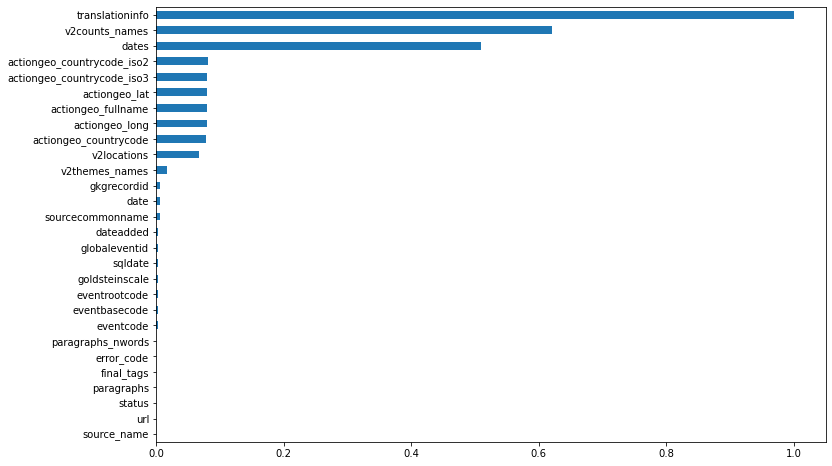

In [32]:
missing_data = news_df.isnull().sum().div(news_df.shape[0])
missing_data.sort_values().plot(kind='barh', figsize=(12, 8))

## Drop uninformative columns

In [33]:
pd.set_option('display.max_colwidth', 50)

cols_to_drop = [
    'translationinfo', # 100% NaN
    'v2counts_names', # more than 60% NaN
    'dates', # strange format with more than 50% NaN
    'sqldate',
    'date',
    'actiongeo_countrycode_iso2', # will use iso3
    'actiongeo_countrycode',
    'globaleventid',
    'gkgrecordid',
    'sourcecommonname', # will use source_name
    'goldsteinscale',
    'actiongeo_lat', 
    'actiongeo_long',
    'v2locations',
    'error_code',
    'status',
    'final_tags'
]

news_df_drop_cols = news_df.drop(cols_to_drop, axis=1)
news_df_drop_cols.head()

,source_name,url,paragraphs,paragraphs_nwords,dateadded,eventrootcode,eventbasecode,eventcode,actiongeo_fullname,actiongeo_countrycode_iso3,v2themes_names
0,www.myanmarnews.net,https://www.myanmarnews.net/news/272606117/un-...,"Voice of America 01 Jul 2022, 04:06 GMT+10 Gen...",573.0,2022-07-01 00:00:00,19.0,190.0,190.0,"Geneva, GenÃ¨, Switzerland",CHE,['AFFECT' 'ARMEDCONFLICT' 'ARREST' 'CRISISLEX_...
1,www.cbsnews.com,https://www.cbsnews.com/news/law-enforcement-c...,"By Jennifer De Pinto, Fred Backus, Anthony Sal...",781.0,2022-07-01 00:00:00,1.0,12.0,12.0,"Uvalde, Texas, United States",USA,['BAN' 'CRISISLEX_C07_SAFETY' 'CRISISLEX_CRISI...
2,www.wkyc.com,https://www.wkyc.com/article/news/nation-world...,Next up in Example video title will go here fo...,996.0,2022-07-01 00:00:00,19.0,190.0,190.0,"Tijuana, Baja California, Mexico",MEX,['AFFECT' 'ARMEDCONFLICT' 'BORDER' 'CRISISLEX_...
3,www.850wftl.com,https://www.850wftl.com/four-dead-three-injure...,"(ENCINAL, Texas) — Four people were killed and...",107.0,2022-07-01 00:00:00,19.0,190.0,190.0,"San Antonio, Texas, United States",USA,['BORDER' 'CRISISLEX_C07_SAFETY' 'CRISISLEX_CR...
4,www.herald.ng,https://www.herald.ng/nigerian-army-confirms-a...,"Get real time updates directly on you device, ...",289.0,2022-07-01 00:00:00,19.0,190.0,190.0,"Shiroro, Niger, Nigeria",NGA,['ARMEDCONFLICT' 'CRISISLEX_CRISISLEXREC' 'ENV...


## Start pre-processing

In [34]:
# drop records with paragraphs_nwords less than 60
mask = news_df_drop_cols['paragraphs_nwords'] >= 60
news_df_preprocessed = news_df_drop_cols[mask]

print(f"- Number of records after removing short paragraphs: {news_df_preprocessed.shape[0]} " 
      f"({round(100 - news_df_preprocessed.shape[0] / news_df_drop_cols.shape[0] * 100., 2)}% records removed)")

news_df_preprocessed['dateadded'] = pd.to_datetime(news_df_preprocessed['dateadded'])

- Number of records after removing short paragraphs: 150195 (3.93% records removed)


In [35]:
# drop records with duplicated paragraphs
news_df_preprocessed_ddp = news_df_preprocessed.drop_duplicates(subset=['paragraphs'], keep='first')

print(">>> De-duping records with same paragraphs")
print(f"- Number of records prior dedupe: {news_df_preprocessed.shape[0]}")
print(f"- Number of records after dedupe: {news_df_preprocessed_ddp.shape[0]} "
      f"({round(100 - news_df_preprocessed_ddp.shape[0] / news_df_preprocessed.shape[0] * 100., 2)}% records removed)")

>>> De-duping records with same paragraphs
- Number of records prior dedupe: 150195
- Number of records after dedupe: 145763 (2.95% records removed)


In [36]:
# Apply light preprocessing
news_df_preprocessed_ddp['body'] = news_df_preprocessed_ddp['paragraphs'].apply(preprocess_body_text)

In [37]:
def remove_advertising_from_body(x, phrase):
    try:
        cleaned_x = x.split(phrase)[0].rstrip()
        return cleaned_x
    except:
        return x

In [38]:
remove_phrases = [
        'the full article is no longer available',
        "Subscribed You've successfully subscribed to this newsletter!",
        'To Read the Full Story',
        'Know about breaking news',
        'All rights reserved',
        'This material, and other digital content on this website, may not be reproduced, published, broadcast, rewritten or redistributed in whole or in part without prior express written permission from',
        'Sorry, there are no recent results for popular commented articles',
        'A link has been emailed to you - check your inbox',
        'We’re glad you’re enjoying this story',
        'Subscribe to any of our plans to continue reading the story',
        'Any citation must be accompanied by a hyperlink to',
        'Republication of any material is prohibited without a written agreement with',
        'There was an error processing your request',
        'Sorry, there are no recent results for popular articles',
        'Special offers from businesses around your area',
        'By clicking Sign Up, I confirm that I have read and agree to the and',
        'Subscribe to to get access',
        'Sign up for our quarterly newsletter',
        'To see more, visit',
        'The latest breaking updates, delivered straight to your email inbox',
        'top headlines are here',
        'Check out what\'s clicking on',
        'Your comment has been submitted',
        'Please avoid obscene, vulgar, lewd, racist or sexually-oriented language',
        'Threats of harming another person will not be tolerated',
        "Don\'t knowingly lie about anyone or anything",
        'No racism, sexism or any sort of -ism that is degrading to another person',
        "Use the 'Report' link on each comment to let us know of abusive posts",
        "We'd love to hear eyewitness accounts, the history behind an article",
        'An email has been sent to with a link to confirm list signup',
        'Breaking news delivered fast',
        'Already a subscriber? Log in!',
        'Get all the stories you need-to-know from the most powerful name in news delivered first thing every morning to your inbox',
        'Email notifications are only sent once a day, and only if there are new matching items.',
        'Get local Breaking News alerts sent directly to your inbox'
    ]

In [39]:
news_df_preprocessed_ddp['cleaned_body'] = news_df_preprocessed_ddp['body']
for phrase in remove_phrases:
    news_df_preprocessed_ddp['cleaned_body'] = news_df_preprocessed_ddp['cleaned_body'].apply(remove_advertising_from_body, args=(phrase,))

In [48]:
cols = ['paragraphs', 'cleaned_body', 'paragraphs_nwords', 'actiongeo_fullname', 'actiongeo_countrycode_iso3']
print(f"Number of records {news_df_preprocessed_ddp[cols].shape[0]}")

fpath_csv = os.path.join(PATH_TO_DATA_ROOT_DIR, r'data_providers\gdelt\scraped_news\scraped_news_text_body_2022-07-01_2022-10-01.csv')
news_df_preprocessed_ddp[cols].to_csv(fpath_csv, index=False)

Number of records 145763


## Saving df subset with USA news and lenght <= 95-th quantile

In [ ]:
news_df_preprocessed_ddp.columns

In [ ]:
usa_mask = news_df_preprocessed_ddp['actiongeo_countrycode_iso3'] == 'USA'
lenght_mask = news_df_preprocessed_ddp['paragraphs_nwords'] <= news_df_preprocessed_ddp['paragraphs_nwords'].quantile(.95)

#usa_subset = pd.DataFrame(news_df_preprocessed_ddp.loc[usa_mask & lenght_mask, 'cleaned_body'].reset_index(drop=True))
#usa_subset = usa_subset.rename(columns={'cleaned_body' : 'text'})


#usa_subset.shape

In [ ]:
usa_subset_csv = news_df_preprocessed_ddp.loc[usa_mask & lenght_mask].reset_index(drop=True)
usa_subset_csv.shape

In [ ]:
fpath_csv = os.path.join(PATH_TO_DATA_ROOT_DIR, r'data_providers\gdelt\scraped_news\usa_news_text_body_2022-07-01_2022-10-01.csv')

usa_subset_csv.to_csv(fpath_csv, index=False)

In [ ]:
usa_subset_csv['cleaned_body'].isnull().sum()